Length of dataframe is 3066766
Column names
Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')
Column types
VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64

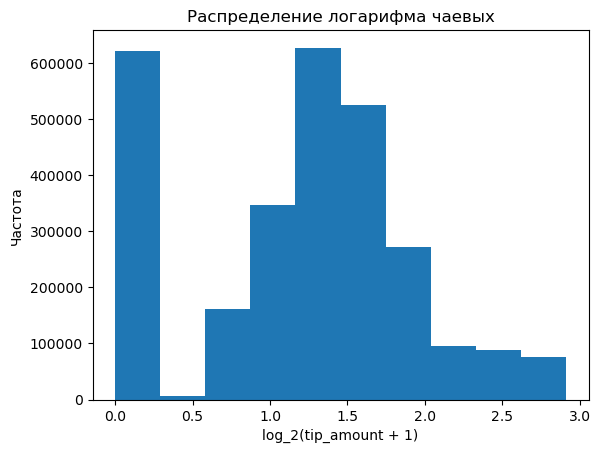

In [1]:
import datetime
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

path_in = 'data.parquet'
# path_out = sys.argv[2]
df = pd.read_parquet(path_in)

print('Length of dataframe is {}'.format(len(df)))

print('Column names')
print(df.columns)

print('Column types')
print(df.dtypes)

print('Dropping total_amount and tolls_amount (they include the target)')
df.drop(columns=['total_amount', 'tolls_amount'], inplace=True)

for col in df.columns:
    print('#unique in {} is {}'.format(col, df[col].nunique()))

for col in df.columns:
    print('percentage of NAs in {} is {:.1f}%'.format(col, 100. * df[col].isna().sum() / len(df)))

print('Droping rows with missing values')
df.dropna(inplace=True)
print('Now length of dataframe is {}'.format(len(df)))

print('Convert Store_and_fwd_flag to number')
df.store_and_fwd_flag = (df.store_and_fwd_flag == 'Y').astype('int64')

for col in df.columns:
    print('Droping rows with anomalous values of {}'.format(col))
    lower_bound = df[col].quantile(0.005)
    upper_bound = df[col].quantile(0.995)

    cond = (df[col] < lower_bound) | (df[col] > upper_bound)
    df.drop(df[cond].index, inplace=True)

    print('Now length of dataframe is {}'.format(len(df)))

target = np.log(df.tip_amount + 1.)
plt.hist(target)
plt.title('Распределение логарифма чаевых')
plt.xlabel('log_2(tip_amount + 1)')
plt.ylabel('Частота')
plt.savefig('target_dist.png')

print('Dropping tip_amount from dataframe')
df.drop(columns=['tip_amount'], inplace=True)

df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime) / datetime.timedelta(minutes=1)
print('Dropping tpep_pickup_datetime and tpep_dropoff_datetime')
pickup_day = df.tpep_pickup_datetime.dt.day
df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)

cols_to_drop = []
for col in df.columns:
    if df[col].nunique() < 300:
        print('Variable {} is categorial, doing one hot encoding of it'.format(col))
        cols_to_drop.append(col)

        for value in df[col].unique():
            new_col_name = '{}=={}'.format(col, value)
            new_col_val = (df[col] == value).astype('int64')
            c = target.corr(new_col_val)
            if (not np.isnan(c)) and abs(c) > 0.015:
                df[new_col_name] = new_col_val  

df.drop(columns=cols_to_drop, inplace=True)

print('Correlations with target:')
for col in df.columns:
    c = target.corr(df[col])
    print('{} {:.2f}'.format(col, c))

result = pd.DataFrame()
result['target'] = target

for i, col in enumerate(df.columns):
    mu = df[col].mean()
    sigma = df[col].std()
    result[str(i)] = (df[col] - mu) / sigma

# df_train1 = result[pickup_day < 12]
# df_train2 = result[(pickup_day >= 12) & (pickup_day < 23)]
# df_test = result[(pickup_day >= 23) & (pickup_day < 26)]
# print("Divide data to train and test by 23.01")
# print(f"Train size: {df_train1.shape[0] + df_train2.shape[0]}")
# print(f"Test size: {df_test.shape[0]}")

# df_train1.to_csv("data_train1.csv")
# df_train2.to_csv("data_train2.csv")
# df_test.to_csv("data_test.csv")


In [16]:
# df_train1 = result[pickup_day == 30].iloc[:25000]
# df_train2 = result[(pickup_day >= 12) & (pickup_day < 23)]
# # df_test = result[(pickup_day >= 23) & (pickup_day < 26)]
df_test = result[(pickup_day == 31)].iloc[:25000]
# print("Divide data to train and test by 23.01")
# print(f"Train size: {df_train1.shape[0] + df_train2.shape[0]}")
# print(f"Test size: {df_test.shape[0]}")

# df_train1.to_excel("data_train1.xlsx")
# df_train2.to_csv("data_train2.csv")
df_test.to_excel("data_test.xlsx")

In [14]:
# df[df.tpep_pickup_datetime.dt.day < 25]

1610975

In [9]:
import sys

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df_train1 = pd.read_parquet("data_train1.parquet")
df_train2 = pd.read_parquet("data_train2.parquet")
df_test = pd.read_parquet("data_test.parquet")

df_train = pd.concat([df_train1, df_train2])
df_train.shape[0]

y_train = df_train.target
X_train = df_train.drop(columns=['target'])
y_test = df_test.target
X_test = df_test.drop(columns=['target'])

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: {:.2f}'.format(mean_squared_error(y_test, y_pred)))


MSE: 0.15


In [14]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(X_train, y_train, verbose=False)

y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

0.12840412798530823

In [16]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=10)
model.fit(X_train, y_train, verbose=False)

y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

0.13051303388396024

In [20]:
import optuna
from catboost import CatBoostRegressor


def objective(trial):
    params = {
        # 'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.00001, 0.1),
        # 'num_leaves' : trial.suggest_int('num_leaves', 20, 60, 4),
        # 'min_child_samples':  trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'depth': trial.suggest_int('depth', 3, 15),
        'random_state': 42,
        'iterations': 100,
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)
    res = mean_squared_error(y_test, y_pred)

    return res


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Best mse:', study.best_value)
print('Best params:', study.best_params)


[I 2023-05-31 18:44:45,615] A new study created in memory with name: no-name-56abf9b7-4a52-4de0-a211-a10d19b6abec
C:\Users\world\AppData\Local\Temp\ipykernel_74296\3077671878.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.00001, 0.1),
[I 2023-05-31 18:44:55,415] Trial 0 finished with value: 0.4558212739788796 and parameters: {'learning_rate': 0.0011398552388028624, 'depth': 3}. Best is trial 0 with value: 0.4558212739788796.
C:\Users\world\AppData\Local\Temp\ipykernel_74296\3077671878.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('l

Best mse: 0.12934236433167767
Best params: {'learning_rate': 0.08617103393610565, 'depth': 6}


In [24]:
from sklearn.linear_model import LogisticRegression, LinearRegression

y_train_0 = (y_train == 0) * 1
model_detect_0 = LogisticRegression()
model_detect_0.fit(X_train, y_train_0)

not_0 = (y_train != 0)
y_train_not_0 = y_train[not_0]
X_train_not_0 = X_train[not_0]
model_regr = LinearRegression()
model_regr.fit(X_train_not_0, y_train_not_0)

LinearRegression()

In [40]:
X_test.loc[is_0.astype(bool)]


,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,76,77,78,79,80,81
index,,,,,,,,,,,,,,,,,,,,,
2102214,-0.575605,-0.804541,-0.299616,0.603465,-0.603465,-0.133394,-0.132536,0.187734,-0.186377,-0.167934,...,-0.067422,-0.599105,-0.277023,-0.063832,-0.084681,-0.088969,-0.251814,0.251814,0.288803,-0.288803
2103001,0.911788,0.772445,0.069083,-1.657097,1.657097,-0.133394,7.545127,0.187734,-0.186377,-0.167934,...,-0.067422,-0.599105,-0.277023,-0.063832,-0.084681,-0.088969,3.971182,-3.971182,-3.462571,3.462571
2103003,2.300907,2.250869,0.355848,0.603465,-0.603465,-0.133394,-0.132536,0.187734,-0.186377,-0.167934,...,-0.067422,-0.599105,-0.277023,-0.063832,-0.084681,11.239804,3.971182,-3.971182,-3.462571,3.462571
2103009,-0.429522,-0.656699,-0.270073,0.603465,-0.603465,-0.133394,-0.132536,0.187734,-0.186377,-0.167934,...,-0.067422,-0.599105,-0.277023,-0.063832,-0.084681,-0.088969,-0.251814,0.251814,0.288803,-0.288803
2103013,1.137553,0.969568,0.083263,0.603465,-0.603465,-0.133394,-0.132536,0.187734,-0.186377,-0.167934,...,-0.067422,-0.599105,-0.277023,-0.063832,-0.084681,-0.088969,-0.251814,0.251814,0.288803,-0.288803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398452,2.869304,2.398711,0.068689,0.603465,-0.603465,-0.133394,-0.132536,0.187734,-0.186377,-0.167934,...,-0.067422,-0.599105,-0.277023,-0.063832,-0.084681,-0.088969,3.971182,-3.971182,0.288803,-0.288803
2398722,-0.129387,-0.361014,-0.195230,0.603465,-0.603465,-0.133394,-0.132536,0.187734,-0.186377,-0.167934,...,-0.067422,-0.599105,-0.277023,-0.063832,-0.084681,-0.088969,-0.251814,0.251814,0.288803,-0.288803
2398753,1.583771,1.314534,0.086809,0.603465,-0.603465,-0.133394,-0.132536,0.187734,-0.186377,-0.167934,...,-0.067422,-0.599105,-0.277023,-0.063832,-0.084681,11.239804,3.971182,-3.971182,-3.462571,3.462571


In [42]:
is_0 = model_detect_0.predict(X_test).astype(bool)
y_pred_not_0 = model_regr.predict(X_test[~is_0])

In [ ]:
y_pred = np.zeros(y_test.shape[0])


In [45]:
mean_squared_error(y_test[~is_0], y_pred)

0.16782694569307008

In [49]:
mean_squared_error(y_test[is_0], np.zeros(is_0.sum()))


0.0014074807696125803